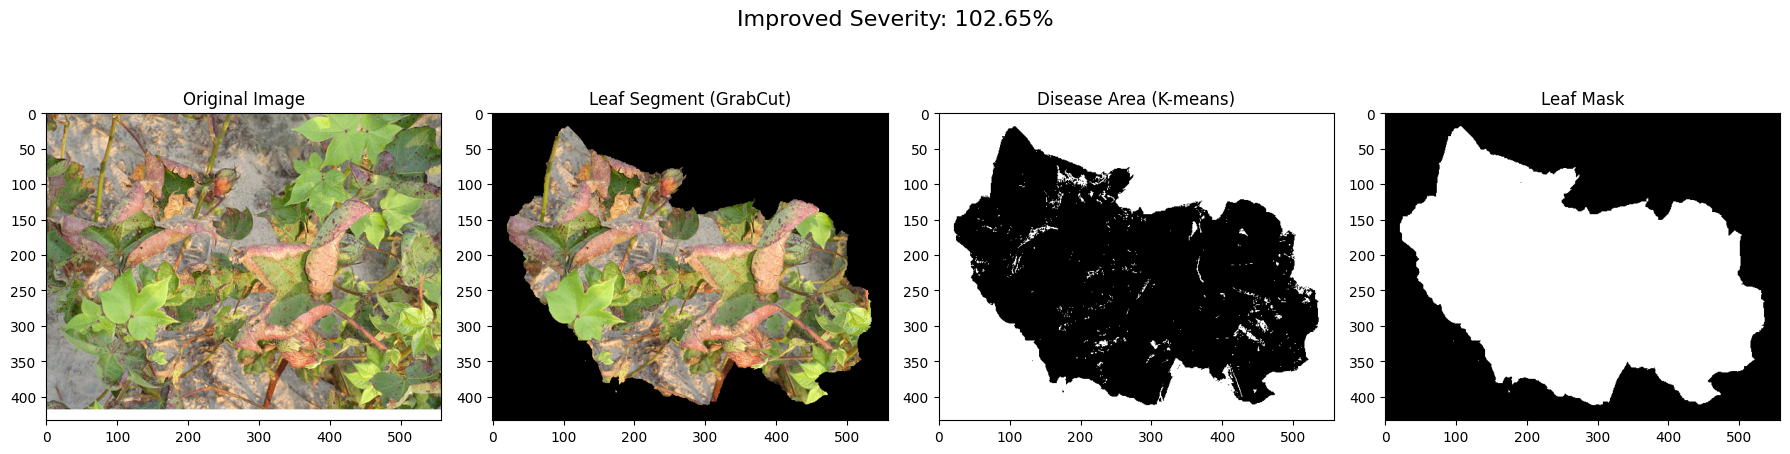

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Step 1: Load the image
image_path = "val/fussarium_wilt/done9.jpg"  # Replace with your file path
original = cv2.imread(image_path)
image = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

# Step 2: GrabCut to segment the leaf from background
mask = np.zeros(image.shape[:2], np.uint8)
bgModel = np.zeros((1, 65), np.float64)
fgModel = np.zeros((1, 65), np.float64)
rect = (20, 20, image.shape[1]-40, image.shape[0]-40)  # rough rectangle around leaf

cv2.grabCut(image, mask, rect, bgModel, fgModel, 5, cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
leaf_segmented = image * mask2[:, :, np.newaxis]

# Step 3: K-means clustering on grayscale leaf area
gray = cv2.cvtColor(leaf_segmented, cv2.COLOR_RGB2GRAY)
Z = gray.reshape((-1, 1)).astype(np.float32)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
_, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Step 4: Assume darker cluster is disease
kmeans_result = labels.flatten().reshape(gray.shape)
disease_mask = (kmeans_result == np.argmin(centers)).astype(np.uint8)
leaf_mask = (mask2 > 0).astype(np.uint8)

# Step 5: Calculate severity
diseased_pixels = np.sum(disease_mask)
leaf_pixels = np.sum(leaf_mask)
severity = (diseased_pixels / leaf_pixels) * 100 if leaf_pixels > 0 else 0

# Step 6: Show output
fig, axs = plt.subplots(1, 4, figsize=(18, 5))
axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[1].imshow(leaf_segmented)
axs[1].set_title("Leaf Segment (GrabCut)")
axs[2].imshow(disease_mask, cmap='gray')
axs[2].set_title("Disease Area (K-means)")
axs[3].imshow(leaf_mask, cmap='gray')
axs[3].set_title("Leaf Mask")

plt.suptitle(f"Improved Severity: {severity:.2f}%", fontsize=16)
plt.tight_layout()
plt.show()